In [1]:
import snap
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from multiprocessing import Pool


def get_features(G, v):
    node = G.GetNI(v)
    deg = node.GetDeg()
    
    egonet = {v} | set(map(node.GetNbrNId, range(deg)))
    
    # Get the induced graph
    eids = snap.TIntV()
    for nid in egonet: 
        eids.Add(nid)
    
    EN = snap.GetSubGraph(G, eids)
    egonet_edges = EN.GetEdges()
    
    # get all of the outgoing edges
    outgoing_edges = 0
    for node in map(G.GetNI, egonet - {v}):
        nbrs = map(node.GetNbrNId, range(node.GetDeg()))
        outgoing_edges += len(filter(lambda x: x not in egonet, nbrs))
    
    return np.array([deg, egonet_edges, outgoing_edges])


def aggregate_features(G, features, v):
    node = G.GetNI(v)
    nbrs = map(node.GetNbrNId, range(node.GetDeg()))
    vec = map(features.get, nbrs)
    # if this node is lonely
    if not vec:
        vec = [np.array([0, 0, 0])]
    return np.concatenate([features[v], np.mean(vec, axis=0), np.sum(vec, axis=0)])


def build_features(G, features, ids, k=2):
    if not k:
        return features
    features_p = map(partial(aggregate_features, G, features), ids)
    return build_features(G, dict(zip(ids, features_p)), ids, k-1)


def cosine_sim(x, y):
    x_norm, y_norm = map(np.linalg.norm, [x, y])
    if not (x_norm and y_norm):
        return 0.0
    return np.dot(x, y)/(x_norm * y_norm)


def discover_roles(G, k):
    """Return a feature table containing higher order features."""
    ids = [n.GetId() for n in G.Nodes()]
    
    features = map(partial(get_features, G), ids)
    initial_features = dict(zip(ids, features))
    
    feature_k = build_features(G, initial_features, ids, k)
    return feature_k

In [2]:
! head ../data/processed/2007-1-enwiki-projection.csv



1	1993024
1	2138537
1	1554195
1	737021
1	3451462
1	211165
1	1512459
1	2803535
1	378390
1	1641816


In [3]:
Rnd = snap.TRnd(42)
Rnd.Randomize()

G = snap.LoadEdgeList(snap.PUNGraph, "../data/processed/2007-1-enwiki-projection.csv")

In [4]:
%time feature_k2 = discover_roles(G, 2)

CPU times: user 4h 14min 12s, sys: 11.1 s, total: 4h 14min 23s
Wall time: 4h 15min 39s


CPU times: user 1.97 s, sys: 8.59 ms, total: 1.98 s
Wall time: 2 s


(array([4.9035e+04, 0.0000e+00, 4.0000e+02, 1.5000e+01, 9.0000e+00,
        6.0000e+00, 0.0000e+00, 0.0000e+00, 4.3000e+01, 0.0000e+00,
        1.4000e+01, 6.0000e+00, 1.7000e+01, 3.0000e+00, 7.0000e+00,
        4.0000e+00, 2.0000e+00, 6.0000e+00, 3.0000e+00, 1.2000e+01,
        1.1000e+01, 1.1000e+01, 1.5000e+01, 1.2000e+01, 1.3000e+01,
        1.7000e+01, 2.0000e+01, 3.1000e+01, 2.4000e+01, 3.0000e+01,
        3.6000e+01, 2.4000e+01, 3.6000e+01, 5.4000e+01, 6.2000e+01,
        8.7000e+01, 7.4000e+01, 7.8000e+01, 1.3700e+02, 1.4800e+02,
        2.2200e+02, 2.5800e+02, 4.0400e+02, 6.4900e+02, 9.8800e+02,
        1.4470e+03, 2.5770e+03, 1.8859e+04, 2.2340e+03, 8.6594e+04]),
 array([0.04192364, 0.06108517, 0.0802467 , 0.09940823, 0.11856975,
        0.13773128, 0.15689281, 0.17605433, 0.19521586, 0.21437739,
        0.23353892, 0.25270044, 0.27186197, 0.2910235 , 0.31018502,
        0.32934655, 0.34850808, 0.3676696 , 0.38683113, 0.40599266,
        0.42515419, 0.44431571, 0.46347724, 0.

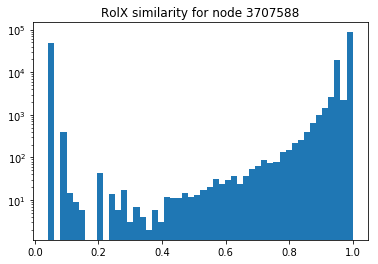

In [30]:
reference_node = G.GetRndNId()
ids = [n.GetId() for n in G.Nodes()]

%time sim = map(partial(cosine_sim, feature_k2[reference_node]), map(feature_k2.get, ids))
plt.title("RolX similarity for node {}".format(reference_node))
plt.hist(sim, bins=50, log=True)

In [26]:
import pandas as pd
pd.DataFrame(feature_k2).to_csv("../data/interim/2007-1-enwiki-projection-roles.csv")

In [31]:
feature_k2

{3932160: array([1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 0.]),
 1: array([7.98000000e+02, 1.48942000e+05, 1.95724300e+06, 2.82497368e+03,
        6.55219612e+05, 1.70839450e+06, 2.25432900e+06, 5.22865250e+08,
        1.36329881e+09, 2.82497368e+03, 6.55219612e+05, 1.70839450e+06,
        2.87110770e+03, 5.41728306e+05, 1.51033419e+06, 3.01600875e+06,
        6.79678209e+08, 3.54033022e+09, 2.25432900e+06, 5.22865250e+08,
        1.36329881e+09, 2.29114394e+06, 4.32299188e+08, 1.20524669e+09,
        2.40677498e+09, 5.42383211e+11, 2.82518351e+12]),
 2: array([5.05000000e+02, 7.55020000e+04, 1.71626000e+06, 3.69655248e+03,
        8.34529826e+05, 1.75509329e+06, 1.86675900e+06, 4.21437562e+08,
        8.86322112e+08, 3.69655248e+03, 8.34529826e+05, 1.75509329e+06,
        2.41030294e+03, 4.73655616e+05, 1.48326771e+06, 3.42045639e+06,
        7.67038502e+08, 4.41011824e+09, 1.86675900e+06, 4.21437562e+08,
        8